In [1]:
import logging
import os
import matplotlib.pyplot as plt
import pandas as pd
from ocean_navigation_simulator.problem_factories.Constructor import (
    Constructor,
)
import yaml
import numpy as np
%load_ext autoreload
%autoreload 2

In [2]:
# Controller Configs
HJMultiTimeConfig = {
    "replan_every_X_seconds": None,
    "replan_on_new_fmrc": True,
    "T_goal_in_seconds": 3600 * 24 * 5,  # 3d, 43200,     # 12h
    "accuracy": "high",
    "artificial_dissipation_scheme": "local_local",
    "ctrl_name": "ocean_navigation_simulator.controllers.hj_planners.HJReach2DPlanner.HJReach2DPlanner",
    "d_max": 0.0,
    "deg_around_xt_xT_box": 1.0,
    "direction": "multi-time-reach-back",
    "grid_res": 0.02,
    "n_time_vector": 200,
    "progress_bar": True,
    "use_geographic_coordinate_system": True,
}
StraightLineConfig = {
    "ctrl_name": "ocean_navigation_simulator.controllers.NaiveController.NaiveController"
}
flockingConfig = {
    "unit": "km",
    "interaction_range": 9,  # km
    "grad_clip_range": 0.1,  # km
    "hysteresis": 0.3,
    "epsilon": 0.5,
}
reactiveConfig = {
    "unit": "m",
    "mix_ttr_and_euclidean": True,
    "delta_3": 8800,  # collision threshold (communication - delta_3)
    "delta_2": 2000,  # safe zone threshold  ]communication - delta_2, communication - delta_3[
    "delta_1": 500,  # small threshold so that if distance > communication_thrsld- delta_1 we try to achieve connectivity
    "communication_thrsld": 9000,
    "k_1": 0.25,
    "k_2": 1,
}
MultiAgentCtrlConfig = {
    "ctrl_name": "ocean_navigation_simulator.controllers.MultiAgentPlanner.MultiAgentPlanner",
    "high_level_ctrl": "hj_naive",  # choose from hj_naive, flocking, reactive_control
    "unit": "km",
    "communication_thrsld": 9,
    "hj_specific_settings": HJMultiTimeConfig,
    "flocking_config": flockingConfig,
    "reactive_control_config": reactiveConfig,
}

In [ ]:
# mission_nr= 195
# missionConfig = {
#       "feasible": True,
#       "multi_agent": True,
#       "target_radius": 0.1,
#       "ttr_in_h": 87.36166002,
#       "x_0": [
#         {
#           "date_time": "2022-05-27T08:01:10+00:00",
#           "lat": 20.451690673828125,
#           "lon": -94.2294921875
#         },
#         {
#           "date_time": "2022-05-27T08:01:10+00:00",
#           "lat": 20.51720428466797,
#           "lon": -94.25813293457031
#         },
#         {
#           "date_time": "2022-05-27T08:01:10+00:00",
#           "lat": 20.490432739257812,
#           "lon": -94.19063568115234
#         },
#         {
#           "date_time": "2022-05-27T08:01:10+00:00",
#           "lat": 20.54242515563965,
#           "lon": -94.2938003540039
#         }
#       ],
#       "x_T": {
#         "lat": 20.09639034,
#         "lon": -95.44171776
#       }
#     }

In [3]:
mission_nr=284
missionConfig= {
      "feasible": True,
      "multi_agent": True,
      "target_radius": 0.1,
      "ttr_in_h": 86.00248514,
      "x_0": [
        {
          "date_time": "2022-05-16T12:49:54+00:00",
          "lat": 25.715316772460938,
          "lon": -87.15331268310547
        },
        {
          "date_time": "2022-05-16T12:49:54+00:00",
          "lat": 25.674318313598633,
          "lon": -87.22444915771484
        },
        {
          "date_time": "2022-05-16T12:49:54+00:00",
          "lat": 25.645584106445312,
          "lon": -87.27655792236328
        },
        {
          "date_time": "2022-05-16T12:49:54+00:00",
          "lat": 25.585601806640625,
          "lon": -87.29128173828125
        }],
      "x_T": {
        "lat": 27.03541637,
        "lon": -86.93996833
      }
}

In [24]:
# Settings for where the problem is saved
my_path = os.getcwd()
save_in_folder = os.path.join(my_path, "generated_media/plots_for_cdc/" + f"mission_nr_{mission_nr}")
os.makedirs(save_in_folder, exist_ok=True)

NoObserver = {"observer": None}

In [5]:
objective_conf = {"type": "nav"}
arenaConfig = {
    "casadi_cache_dict": {"deg_around_x_t": 0.5, "time_around_x_t": 86400.0},
    "ocean_dict": {
        "hindcast": {
            "field": "OceanCurrents",
            "source": "hindcast_files",
            "source_settings": {
                "folder": "data/miss_gen_hindcast/",
                "local": False,
                "source": "HYCOM",
                "type": "hindcast",
                "currents": "total",
                "region": "GOM",
                # "region": "Region 1",
            },
        },
        "forecast": None,  # {
        #     "field": "OceanCurrents",
        #     "source": "forecast_files",
        #     "source_settings": {
        #         "folder": "data/miss_gen_forecast/",
        #         "local": False,
        #         "source": "Copernicus",
        #         "type": "forecast",
        #         "currents": "total",
        #         "region": "GOM",
        #     },
        # },
        # "forecast": {
        #     "field": "OceanCurrents",
        #     "source": "hindcast_as_forecast_files",
        #     "source_settings": {
        #         "folder": "data/miss_gen_forecast/",
        #         "local": False,
        #         "source": "Copernicus",
        #         "type": "hindcast",
        #         "currents": "total",
        #         "region": "GOM",
        #     },
        #     "forecast_length_in_days": 5,
        # },
    },
    "platform_dict": {
        "battery_cap_in_wh": 400.0,
        "drag_factor": 675.0,
        "dt_in_s": 600.0,
        "motor_efficiency": 1.0,
        "solar_efficiency": 0.2,
        "solar_panel_size": 0.5,
        "u_max_in_mps": 0.1,
    },
    "seaweed_dict": {"forecast": None, "hindcast": None},
    "solar_dict": {"forecast": None, "hindcast": None},
    "spatial_boundary": None,
    "use_geographic_coordinate_system": True,
    "timeout": 3600 * 24 * 4,  # CHANGE TIMOUT HERE
    "multi_agent_constraints": {
        "unit": "km",
        "communication_thrsld": 9,
        "epsilon_margin": 0.3,  # when add edges based on hysteresis
        "collision_thrsld": 0.2,
    },
}

In [6]:
# Step 0: Create Constructor object which contains arena, problem, controller and observer
constructor = Constructor(
    arena_conf=arenaConfig,
    mission_conf=missionConfig,
    objective_conf=objective_conf,
    ctrl_conf=MultiAgentCtrlConfig,  # here different controller configs can be put in
    observer_conf=NoObserver,  # here the other observers can also be put int
    download_files=True,  # True,,
)
# Step 1.1 Retrieve problem
problem = constructor.problem

#Step 1.2: Retrieve arena
arena = constructor.arena
observation = arena.reset(platform_set=problem.start_state)
problem_status = arena.problem_status(problem=problem)

Starting to connect to c3


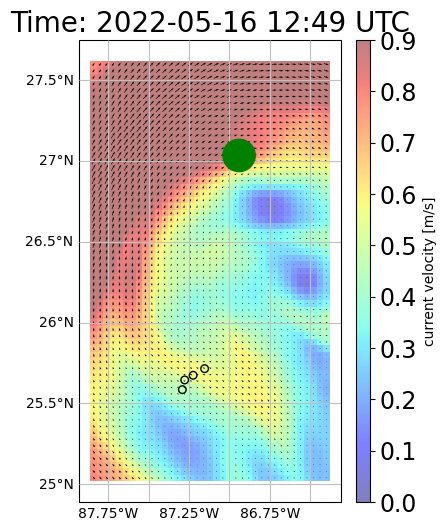

In [20]:
import matplotlib.pyplot as plt

t_interval, lat_bnds, lon_bnds = arena.ocean_field.hindcast_data_source.convert_to_x_y_time_bounds(
    x_0=problem.start_state.to_spatio_temporal_point(),
    x_T=problem.end_region,
    deg_around_x0_xT_box=0.5,
    temp_horizon_in_s=3600,
)

ax = arena.ocean_field.hindcast_data_source.plot_data_at_time_over_area(
    time=problem.start_state.date_time[0],
    x_interval=lon_bnds,
    y_interval=lat_bnds,
    return_ax=True,
    vmax=0.9,
)
problem.plot(ax=ax)
plt.show()
# fig= plt.figure()
# cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
# plt.colorbar(cax=cax)
# ax.get_figure().show()

In [21]:
# Step 2: Retrieve Controller
# problem.platform_dict = arena.platform.platform_dict
controller = constructor.controller
# Step 3: Retrieve observer
observer = constructor.observer
observer.observe(observation)
observation.forecast_data_source = observer


# Reachability snapshot plot and to initiate planning (so that we dont take it account later in the solver time)
action = controller.get_action(observation=observation)

100%|##########|  1.0000/1.0 [00:24<00:00, 24.87s/sim_s]


/home/nicolas/miniconda3/envs/ocean_minimal/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning:

No contour levels were found within the data range.



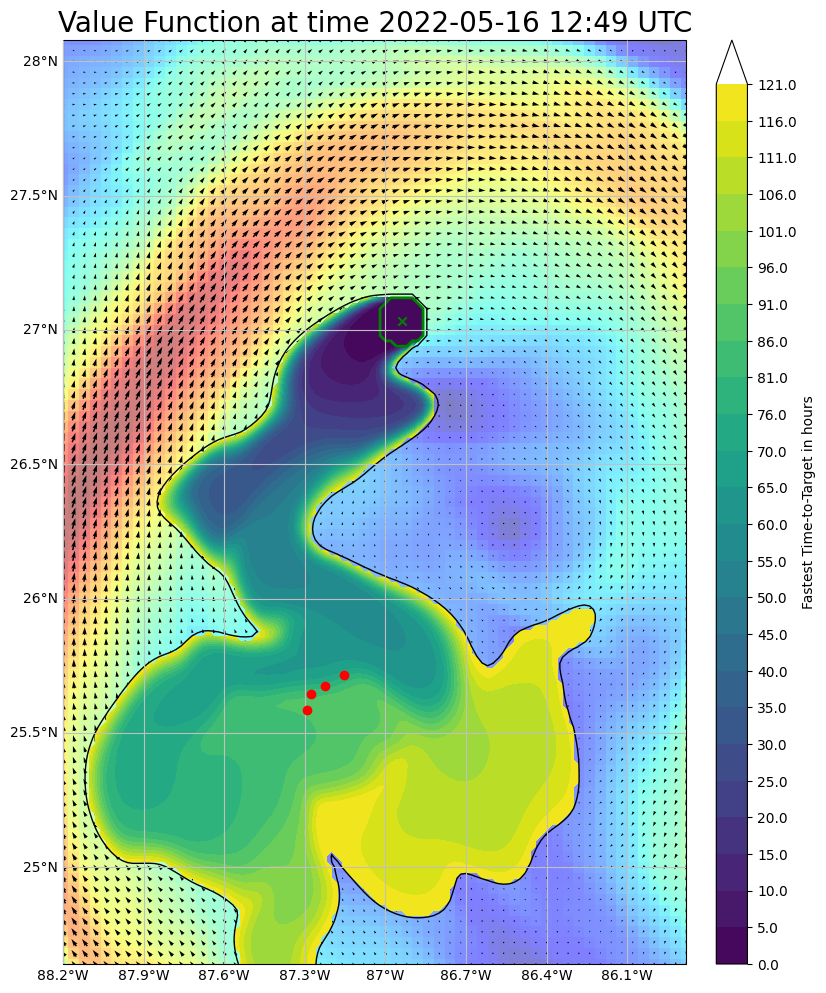

terminated because: Running


In [22]:
# Step 4: Run closed-loop simulation
controller.plot_reachability_snapshot_over_currents(
    rel_time_in_seconds=0,
    granularity_in_h=5,
    alpha_color=1,
    time_to_reach=True,
    fig_size_inches=(12, 12),
    return_ax=True,
)
plt.show()
ctrl_deviation_from_opt = []
solver_times = []
all_pltf_status = [0] * len(missionConfig["x_0"])
min_distances_to_target_over_mission = [np.inf] * len(missionConfig["x_0"])
pb_running_thrsld = 0
# Run until tiemout of until one of the platform has stranded/left arena region (failed)
#while not any(status < pb_running_thrsld for status in problem_status):
for i in range(100):
    # Get action
    action, ctrl_correction, solver_time_step_s = controller.get_action(
        observation=observation
    )  # correction angle in rad
    ctrl_deviation_from_opt.append(ctrl_correction)

    # append solver time
    solver_times.append(solver_time_step_s)
    # execute action
    observation = arena.step(action)

    # Observer data assimilation
    observer.observe(observation)
    observation.forecast_data_source = observer
    # #this replaces the forecast source by Observer (defined as none for now so not a desired behavior)

    # update problem status
    problem_status = arena.problem_status(problem=problem)
    min_distances_to_target_over_mission = arena.get_min_or_max_of_two_lists(
        list_a=min_distances_to_target_over_mission,
        list_b=arena.final_distance_to_target(problem=problem),
        min_or_max="min",
    )
    # for the final metric, look if platform was able to reach target within T, so keep only max (=1 if pltf reached target)
    all_pltf_status = arena.get_min_or_max_of_two_lists(
        list_a=all_pltf_status, list_b=problem_status, min_or_max="max"
    )
print("terminated because:", arena.problem_status_text(arena.problem_status(problem=problem)))


In [ ]:
results_folder = os.path.join(
    save_in_folder, MultiAgentCtrlConfig["high_level_ctrl"]
)
os.makedirs(results_folder, exist_ok=True)

with open(f"{results_folder}/missionConfig.yml", "w") as outfile:
    yaml.dump(missionConfig, outfile, default_flow_style=False)

metrics_dict = arena.save_metrics_to_log(
    all_pltf_status=all_pltf_status,
    min_distances_to_target=min_distances_to_target_over_mission,
    max_correction_from_opt_ctrl=ctrl_deviation_from_opt,
    solver_times=solver_times,
    filename=f"{results_folder}/metrics.log",
)
metrics_df = pd.DataFrame(data=metrics_dict, index=[0])
metrics_df.to_csv(f"{results_folder}/metrics.csv")
arena.animate_trajectory(
    margin=0.1,
    problem=problem,
    temporal_resolution=7200,
    output=f"{results_folder}/trajectory_anim.mp4",
    fps=6,
    ctrl_scale=20,
)

arena.animate_graph_net_trajectory(
    temporal_resolution=7200,
    # collision_communication_thrslds=(10, 50), (not specified take defaut one)
    plot_ax_ticks=True,
    output=f"{results_folder}/network_graph_anim.mp4",
    fps=5,
)

plt.clf()
fig = arena.plot_all_network_analysis(xticks_temporal_res=12 * 3600)  # 8 hours interval for xticks
plt.savefig(f"{results_folder}/graph_properties.png")

plt.clf()
arena.plot_all_on_map(problem=problem, show_control_trajectory=False, margin=0.25, return_ax=True)
plt.savefig(f"{results_folder}/state_trajectory.png")

plt.clf()
arena.plot_distance_evolution_between_platforms()
plt.savefig(f"{results_folder}/distanceEvolution.png")

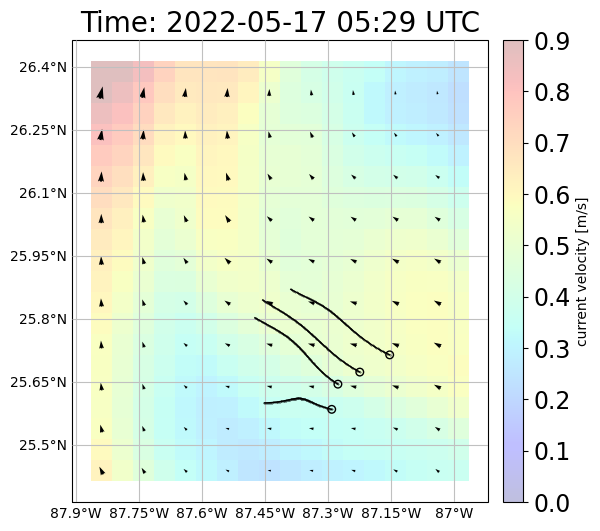

In [26]:
#%matplotlib
results_folder = os.path.join(
    save_in_folder, MultiAgentCtrlConfig["high_level_ctrl"]
)
ax = arena.plot_all_on_map(problem=problem, x_interval=[-87.8,-87],
        y_interval=[25.5,26.4],show_current_position =False, show_control_trajectory=False, margin=0.25, return_ax=True,
                vmax=0.9,
                alpha=0.25,
                quiver_scale=30,
                quiver_spatial_res=0.1,
                )
plt.savefig(f"{results_folder}/state_trajectory_zoom_without_current_state_black_alpha_0.25_spatial_res0_05.png", dpi=1200)


# Comparison of datasources

In [48]:
import logging
import os
import matplotlib.pyplot as plt
import pandas as pd
from ocean_navigation_simulator.problem_factories.Constructor import (
    Constructor,
)
import yaml
import numpy as np
%load_ext autoreload
%autoreload 2
my_path = os.getcwd()
save_in_folder = os.path.join(my_path, "generated_media/plots_for_cdc/")
os.makedirs(save_in_folder, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
arenaConfig = {
    "casadi_cache_dict": {"deg_around_x_t": 0.5, "time_around_x_t": 86400.0},
    "ocean_dict": {
        "hindcast": {
            "field": "OceanCurrents",
            "source": "hindcast_files",
            "source_settings": {
                "folder": "data/miss_gen_hindcast/",
                "local": False,
                "source": "HYCOM",
                "type": "hindcast",
                "currents": "total",
                "region": "GOM",
                # "region": "Region 1",
            },
        },
        #"forecast": None,  # {
        #     "field": "OceanCurrents",
        #     "source": "forecast_files",
        #     "source_settings": {
        #         "folder": "data/miss_gen_forecast/",
        #         "local": False,
        #         "source": "Copernicus",
        #         "type": "forecast",
        #         "currents": "total",
        #         "region": "GOM",
        #     },
        # },
        "forecast": {
            "field": "OceanCurrents",
            "source": "hindcast_as_forecast_files",
            "source_settings": {
                "folder": "data/miss_gen_forecast/",
                "local": False,
                "source": "Copernicus",
                "type": "hindcast",
                "currents": "total",
                "region": "GOM",
            },
            "forecast_length_in_days": 5,
        },
    },
    "platform_dict": {
        "battery_cap_in_wh": 400.0,
        "drag_factor": 675.0,
        "dt_in_s": 600.0,
        "motor_efficiency": 1.0,
        "solar_efficiency": 0.2,
        "solar_panel_size": 0.5,
        "u_max_in_mps": 0.1,
    },
    "seaweed_dict": {"forecast": None, "hindcast": None},
    "solar_dict": {"forecast": None, "hindcast": None},
    "spatial_boundary": None,
    "use_geographic_coordinate_system": False,
    "timeout": 3600 * 24 * 4,  # CHANGE TIMOUT HERE
    "multi_agent_constraints": {
        "unit": "km",
        "communication_thrsld": 9,
        "epsilon_margin": 0.3,  # when add edges based on hysteresis
        "collision_thrsld": 0.2,
    },
}
HJMultiTimeConfig = {
    "replan_every_X_seconds": None,
    "replan_on_new_fmrc": True,
    "T_goal_in_seconds": 3600 * 24 * 5,  # 3d, 43200,     # 12h
    "accuracy": "high",
    "artificial_dissipation_scheme": "local_local",
    "ctrl_name": "ocean_navigation_simulator.controllers.hj_planners.HJReach2DPlanner.HJReach2DPlanner",
    "d_max": 0.0,
    "deg_around_xt_xT_box": 1.0,
    "direction": "multi-time-reach-back",
    "grid_res": 0.02,
    "n_time_vector": 200,
    "progress_bar": True,
    "use_geographic_coordinate_system": True,
}
MultiAgentCtrlConfig = {
    "ctrl_name": "ocean_navigation_simulator.controllers.MultiAgentPlanner.MultiAgentPlanner",
    "high_level_ctrl": "hj_naive",  # choose from hj_naive, flocking, reactive_control
    "unit": "km",
    "communication_thrsld": 9,
    "hj_specific_settings": HJMultiTimeConfig,
}

mission_nr=284
missionConfig= {
      "feasible": True,
      "multi_agent": True,
      "target_radius": 0.1,
      "ttr_in_h": 86.00248514,
      "x_0": [
        {
          "date_time": "2022-08-16T12:49:54+00:00",
          "lat": 25.715316772460938,
          "lon": -87.15331268310547
        },
        {
          "date_time": "2022-08-16T12:49:54+00:00",
          "lat": 25.674318313598633,
          "lon": -87.22444915771484
        },
        {
          "date_time": "2022-08-16T12:49:54+00:00",
          "lat": 25.645584106445312,
          "lon": -87.27655792236328
        },
        {
          "date_time": "2022-08-16T12:49:54+00:00",
          "lat": 25.585601806640625,
          "lon": -87.29128173828125
        }],
      "x_T": {
        "lat": 27.03541637,
        "lon": -86.93996833
      }
}
NoObserver = {"observer": None}
objective_conf = {"type": "nav"}

In [62]:
# Step 0: Create Constructor object which contains arena, problem, controller and observer
constructor = Constructor(
    arena_conf=arenaConfig,
    mission_conf=missionConfig,
    objective_conf=objective_conf,
    ctrl_conf=MultiAgentCtrlConfig,  # here different controller configs can be put in
    observer_conf=NoObserver,  # here the other observers can also be put int
    download_files=True,  # True,,
)
# Step 1.1 Retrieve problem
problem = constructor.problem

#Step 1.2: Retrieve arena
arena = constructor.arena
# observation = arena.reset(platform_set=problem.start_state)
# problem_status = arena.problem_status(problem=problem)

[datetime.datetime(2022, 8, 16, 12, 49, 54, tzinfo=datetime.timezone.utc), datetime.datetime(2022, 8, 21, 14, 49, 54, tzinfo=datetime.timezone.utc)]
[datetime.datetime(2022, 8, 14, 12, 49, 54, tzinfo=datetime.timezone.utc), datetime.datetime(2022, 8, 26, 14, 49, 54, tzinfo=datetime.timezone.utc)]


In [53]:
%matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
im = arena.ocean_field.hindcast_data_source.plot_data_at_time_over_area(
    time=problem.start_state.date_time[0],
    x_interval= [-96, -78],
    y_interval=[20, 29],
    return_ax=True,
    vmax=1,
    alpha=0.7, 
    quiver_scale=125,
    quiver_spatial_res=0.2,
    ax=ax
) 
# fig.savefig("hindcast_hycom.png", dpi=600)
fig.savefig("hindcast_hycom.pdf")
fig, ax = plt.subplots(figsize=(10, 6))
im = arena.ocean_field.forecast_data_source.plot_data_at_time_over_area(
    time=problem.start_state.date_time[0],
    x_interval= [-96, -78],
    y_interval=[20, 29],
    return_ax=True,
    vmax=1,
    alpha=0.7, 
    quiver_scale=150,
    quiver_spatial_res=0.2,
    ax=ax,

)
#fig.savefig("forecast_as_hindcast_copernicus.png", dpi=600)
fig.savefig("forecast_as_hindcast_copernicus.pdf")


Using matplotlib backend: TkAgg


In [86]:
%matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
im = arena.ocean_field.hindcast_data_source.plot_data_at_time_over_area(
    time=problem.start_state.date_time[0],
    x_interval= [-96, -78],
    y_interval=[20, 29],
    return_ax=True,
    vmax=1,
    alpha=0.7, 
    quiver_scale=125,
    quiver_spatial_res=0.2,
    ax=ax
) 

Using matplotlib backend: TkAgg


In [100]:
fig, ax = plt.subplots(figsize=(8, 6))
ax = arena.ocean_field.hindcast_data_source.plot_data_at_time_over_area(
    time=problem.start_state.date_time[0],
    x_interval= [-91, -90],
    y_interval=[26.6, 27.5],
    return_ax=True,
    vmax=1.4,
    alpha=0.4, 
    quiver_scale=25,
    quiver_spatial_res=0.15,
    quiver_headwidth=2,
    ax=ax
) 
fig.savefig(f"{save_in_folder}/ocean_data_disconnection.png", dpi=800)

In [101]:
fig, ax = plt.subplots(figsize=(8, 6))
ax = arena.ocean_field.hindcast_data_source.plot_data_at_time_over_area(
    time=problem.start_state.date_time[0],
    x_interval= [-86.1, -85.3],
    y_interval=[20.5, 21.5],
    return_ax=True,
    vmax=1.4,
    alpha=0.4, 
    quiver_scale=25,
    quiver_spatial_res=0.15,
    quiver_headwidth=2,
    ax=ax
) 
fig.savefig(f"{save_in_folder}/ocean_data_collision.png", dpi=800)

In [102]:
fig, ax = plt.subplots(figsize=(8, 6))
ax = arena.ocean_field.hindcast_data_source.plot_data_at_time_over_area(
    time=problem.start_state.date_time[0],
    x_interval= [-86.6, -85.6],
    y_interval=[20.5, 22],
    return_ax=True,
    vmax=1.4,
    alpha=0.4, 
    quiver_scale=25,
    quiver_spatial_res=0.15,
    quiver_headwidth=2,
    ax=ax
) 
fig.savefig(f"{save_in_folder}/ocean_data_easy.png", dpi=800)

invalid command name "140124152587840delayed_destroy"
    while executing
"140124152587840delayed_destroy"
    ("after" script)
invalid command name "140124149479424delayed_destroy"
    while executing
"140124149479424delayed_destroy"
    ("after" script)
invalid command name "140124149450560delayed_destroy"
    while executing
"140124149450560delayed_destroy"
    ("after" script)
